# Create a MajorTOM grid

In [1]:
import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box

from deepfreezer.grid import MajorTOMGrid
from deepfreezer.utils import ROOT_DIR

Create a 500 km spaced grid for visualization purposes

In [2]:
DIST_M = 500_000

grid = MajorTOMGrid(dist=DIST_M)

# Remove points close to the poles
grid = grid.filter(box(-180, -85, 180, 85))
grid.df.head()

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone
2,0,1,-180.000000,-85.609756,51.428571,00b0bp0p,EPSG:32709
3,1,1,-128.571429,-85.609756,51.428571,10u8fr1p,EPSG:32718
4,2,1,-77.142857,-85.609756,51.428571,42c0ux4r,EPSG:32726
5,3,1,-25.714286,-85.609756,51.428571,52v8yz5r,EPSG:32735
6,4,1,25.714286,-85.609756,51.428571,h8f2cphx,EPSG:32743


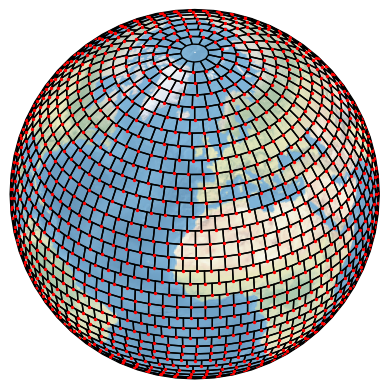

In [3]:
proj = ccrs.Orthographic(-10, 40)

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_global()
ax.stock_img()
grid.get_cells().plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.Geodetic()
)
grid.get_points().plot(
    ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3
);


Test filtering with arbitray shaped geometries

In [4]:
aoi = Polygon(
    [
        [-10, 10],
        [5, 10],
        [5, 40],
        [20, 40],
        [20, 10],
        [30, 10],
        [30, 65],
        [-10, 65],
        [-10, 10],
    ]
)
grid_aoi = grid.filter(aoi)

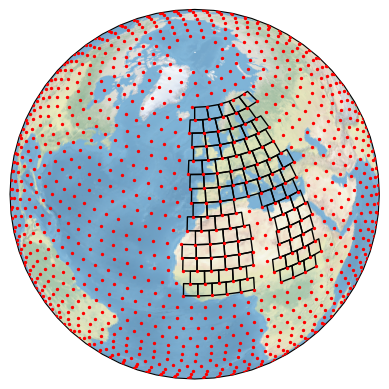

In [5]:
proj = ccrs.Orthographic(-10, 40)

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_global()
ax.stock_img()
grid_aoi.get_cells().plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.Geodetic()
)
grid.get_points().plot(
    ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3
);

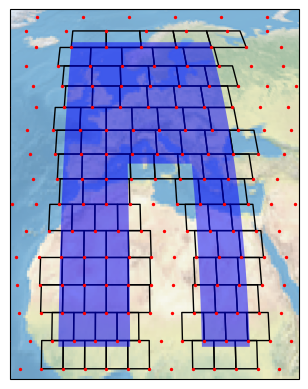

In [6]:
proj = ccrs.EqualEarth()
proj.threshold = proj.threshold / 100.0

fig, ax = plt.subplots(subplot_kw={"projection": proj})

ax.set_extent([-20, 40, 5, 75], crs=ccrs.PlateCarree())
ax.stock_img()
grid_aoi.get_cells().plot(
    ax=ax, edgecolor="black", facecolor="None", transform=ccrs.PlateCarree()
)
gpd.GeoSeries(aoi, crs=4326).plot(
    ax=ax, color="blue", alpha=0.5, transform=ccrs.PlateCarree()
)
grid.get_points().plot(
    ax=ax, markersize=2, color="red", transform=ccrs.PlateCarree(), zorder=3
);

Create a 10 km grid and only keep cells intersecting with Switzerland's glaciers

In [7]:
sgi = gpd.read_file(ROOT_DIR / "data/raw/inventory_sgi2016_r2020/SGI_2016_glaciers.shp")

WGS84 = "EPSG:4326"
CEA = "+proj=cea"

# Clean file
sgi = sgi.drop(columns="pk_glacier")
sgi.gid = sgi.gid.astype(int)
sgi = sgi.set_index("gid", verify_integrity=True).sort_index().to_crs(WGS84)

# Get a single shape of the union
sgi_union = sgi.union_all()

In [8]:
grid_sgi = MajorTOMGrid(dist=10_000).filter(sgi_union)
cells_sgi = grid_sgi.get_cells(buffer_ratio=0.1)
cells_sgi.head()

,lon_idx,lat_idx,lon,lat,lon_spacing,id,utm_zone,geometry
4390552,1452,1512,7.086614,45.808383,0.128848,u0jh970m,EPSG:32632,"POLYGON ((7.07373 45.7994, 7.22835 45.7994, 7...."
4390553,1453,1512,7.215462,45.808383,0.128848,u0jhs5nj,EPSG:32632,"POLYGON ((7.20258 45.7994, 7.35719 45.7994, 7...."
4390554,1454,1512,7.344309,45.808383,0.128848,u0jhx55v,EPSG:32632,"POLYGON ((7.33142 45.7994, 7.48604 45.7994, 7...."
4393342,1448,1513,6.905701,45.898204,0.129079,u0hvj5s8,EPSG:32632,"POLYGON ((6.89279 45.88922, 7.04769 45.88922, ..."
4393343,1449,1513,7.034779,45.898204,0.129079,u0jj05d8,EPSG:32632,"POLYGON ((7.02187 45.88922, 7.17677 45.88922, ..."


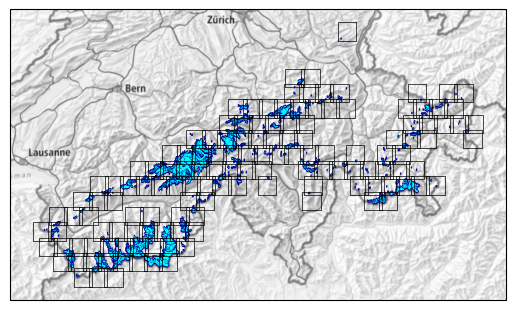

In [9]:
# Add buffer to SGI for visualization
sgi_buffered = sgi.to_crs(CEA).simplify(100).buffer(500).to_crs(WGS84)

proj = ccrs.UTM(32)
fig, ax = plt.subplots(subplot_kw={"projection": proj})

sgi_buffered.plot(ax=ax, color="darkblue")
sgi.plot(ax=ax, color="cyan")
cells_sgi.plot(ax=ax, edgecolor="black", linewidth=0.5, color="None")

cx.add_basemap(
    ax,
    crs=sgi.crs,
    # source=cx.providers.OpenStreetMap.Mapnik,
    source=cx.providers.SwissFederalGeoportal.NationalMapGrey,
    attribution=False,
)
